# Project: Recognizing Traffic Signs Using Deep Learning
### Scope: Classifier: Sklearn's MLPClassifier Neural Net Investigation on tunning hyper-parameters
##### Author: Ashish Panchal (epababl03.ashishp@iima.ac.in)

In [99]:
# Import Libraries
import warnings
from sklearn.exceptions import ConvergenceWarning

import sys
import os
import seaborn
import numpy as np
from os import path
import cv2
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MinMaxScaler


from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

# Local python modules
sys.path.insert(0, os.path.abspath('../src/util'))
sys.path.insert(1, os.path.abspath('../src/model'))
sys.path.insert(2, os.path.abspath('../src/data'))
from util import Util
from load_save import LoadSave
from datapreprocessor import preprocess

# GLOBAL PARAM
CHART_WIDTH = 12
CHART_HEIGHT = 8

In [2]:
#Load stored data

#No. of classes
%store -r n_classes

# class labels
%store -r signs

#Final preprocessed Training Dataset
%store -r X_train_preprocessed
%store -r y_train_final

#Final preprocessed Test Dataset
%store -r X_test_preprocessed
%store -r y_test


#Final preprocessed Validation Dataset
%store -r X_valid_preprocessed 
%store -r y_valid

#### Verify pre-processed Training, Test, and Validation datasets

In [3]:
print(X_train_preprocessed.shape)
print(y_train_final.shape)
print(X_valid_preprocessed.shape)
print(y_valid.shape)

(39239, 32, 32, 1)
(39239,)
(4410, 32, 32, 1)
(4410,)


### 5.1 Hyper-parameters of MLP

We have tried RandomizedSearchCV to find optimized set of hyper-parameters. we tried following combination:
1. hidden_layer_sizes':(1024,)
   Test Accuracy: 82.9% 
   New Test Images Accuracy: 30%
2. hidden_layer_sizes':(32,64,43)
   Test Accuracy: 80% 
   New Test Images Accuracy: 20%
3. hidden_layer_sizes':(100,64,43)
   Test Accuracy: 81% 
   New Test Images Accuracy: 25%
4. hidden_layer_sizes':(1024,1024,43)
   Test Accuracy: 83% 
   New Test Images Accuracy: 20%
5. hidden_layer_sizes':(1024,750,43)
   Test Accuracy: 83% 
   New Test Images Accuracy: 20%  

- As we can see that, #1 and #5 has almost same test accuracy but have significant  different performance/accuracy on new test images. So we have selected #1.
- Best Parameter found is:
{'solver': 'sgd', 'max_iter': 1000, 'hidden_layer_sizes': (1024, 750, 43), 'alpha': 0.001}

In [81]:
# Find hyper parameters for MLP
parameters = {
    'solver': ['sgd', 'adam'], 
    'max_iter': [1000], 
    'alpha': 10.0 ** -np.arange(3, 6), 
    'hidden_layer_sizes':[(1024,750,43)]
}
X_train = X_train_preprocessed.reshape((len(X_train_preprocessed)),-1)

In [82]:
random_search_clf = RandomizedSearchCV(MLPClassifier(), parameters, n_jobs=10, cv=3, verbose=10)
random_search_clf.fit(X_train, y_train_final)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/apanchal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  18 | elapsed: 45.2min remaining: 226.1min
[Parallel(n_jobs=10)]: Done   5 out of  18 | elapsed: 83.9min remaining: 218.3min
[Parallel(n_jobs=10)]: Done   7 out of  18 | elapsed: 142.9min remaining: 224.6min
[Parallel(n_jobs=10)]: Done   9 out of  18 | elapsed: 237.8min remaining: 237.8min
[Parallel(n_jobs=10)]: Done  11 out of  18 | elapsed: 255.5min remaining: 162.6min
[Parallel(n_jobs=10)]: Done  13 out of  18 | elapsed: 262.3min remaining: 100.9min
[Parallel(n_jobs=10)]: Done  15 out of  18 | elapsed: 277.4min remaining: 55.5min
[Parallel(n_jobs=10)]: Done  18 out of  18 | elapsed: 280.4m

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=200,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                           solver='adam', tol=0.0001,
                                           validation_fraction=0.1,
                                         

In [83]:
print(random_search_clf.best_estimator_)
print(random_search_clf.best_params_)


MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1024, 750, 43), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
{'solver': 'sgd', 'max_iter': 1000, 'hidden_layer_sizes': (1024, 750, 43), 'alpha': 0.001}


In [85]:
print(random_search_clf.cv_results_)

{'mean_fit_time': array([15658.17464161,  2539.40917397, 15731.29035433,  3049.35215537,
       13231.83929308,  2682.89880093]), 'std_fit_time': array([ 808.10634114,  225.25501591,  331.85125584,  606.15854289,
       1027.72718868,  231.91339082]), 'mean_score_time': array([3.26422898, 5.41603462, 2.78493412, 4.86847798, 1.42720254,
       3.45309591]), 'std_score_time': array([1.3316937 , 0.08435888, 0.76277466, 0.55289417, 0.18206223,
       0.31161023]), 'param_solver': masked_array(data=['sgd', 'adam', 'sgd', 'adam', 'sgd', 'adam'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_iter': masked_array(data=[1000, 1000, 1000, 1000, 1000, 1000],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_hidden_layer_sizes': masked_array(data=[(1024, 750, 43), (1024, 750, 43), (1024, 750, 43),
                   (1024, 750, 43), (1024, 750, 43), (1024

### 5.2 Different learning rate schedules and momentum parameters (Comparing different learning strategies for the network)

training: constant learning-rate
Iteration 1, loss = 3.68071765
Iteration 2, loss = 3.53682126
Iteration 3, loss = 3.47035109
Iteration 4, loss = 3.41277791
Iteration 5, loss = 3.35982796
Iteration 6, loss = 3.30973905
Iteration 7, loss = 3.26211948
Iteration 8, loss = 3.21671800
Iteration 9, loss = 3.17334651
Iteration 10, loss = 3.13173425
Iteration 11, loss = 3.09151039
Iteration 12, loss = 3.05239499
Iteration 13, loss = 3.01441456
Iteration 14, loss = 2.97733875
Iteration 15, loss = 2.94109069
Iteration 16, loss = 2.90570726
Iteration 17, loss = 2.87125151
Iteration 18, loss = 2.83780828
Iteration 19, loss = 2.80499070
Iteration 20, loss = 2.77307131
Iteration 21, loss = 2.74185488
Iteration 22, loss = 2.71156192
Iteration 23, loss = 2.68214886
Iteration 24, loss = 2.65327140
Iteration 25, loss = 2.62525806
Iteration 26, loss = 2.59787204
Iteration 27, loss = 2.57139970
Iteration 28, loss = 2.54560544
Iteration 29, loss = 2.52023250
Iteration 30, loss = 2.49577774
Iteration 31, lo

/Users/apanchal/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.921022
Training set loss: 0.381903

training: constant with momentum
Iteration 1, loss = 3.36477609
Iteration 2, loss = 3.40555942
Iteration 3, loss = 3.52892707
Iteration 4, loss = 3.46503902
Iteration 5, loss = 3.61797631
Iteration 6, loss = 3.61322611
Iteration 7, loss = 3.61678532
Iteration 8, loss = 3.61679280
Iteration 9, loss = 3.61693153
Iteration 10, loss = 3.60753079
Iteration 11, loss = 3.61702264
Iteration 12, loss = 3.61679882
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training set score: 0.048166
Training set loss: 3.616799

training: constant with Nesterov's momentum
Iteration 1, loss = 3.76462675
Iteration 2, loss = 3.61847568
Iteration 3, loss = 3.61337781
Iteration 4, loss = 3.51285695
Iteration 5, loss = 3.61384106
Iteration 6, loss = 3.62762738
Iteration 7, loss = 3.62322263
Iteration 8, loss = 3.62603353
Iteration 9, loss = 3.62728438
Iteration 10, loss = 3.62715030
Iteration 11, loss = 3.62721443

/Users/apanchal/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.717373
Training set loss: 1.194639

training: inv-scaling with momentum
Iteration 1, loss = 3.76462675
Iteration 2, loss = 3.62075446
Iteration 3, loss = 3.51392594
Iteration 4, loss = 3.49949019
Iteration 5, loss = 3.48846176
Iteration 6, loss = 3.47943869
Iteration 7, loss = 3.47130969
Iteration 8, loss = 3.46411397
Iteration 9, loss = 3.45771166
Iteration 10, loss = 3.45196652
Iteration 11, loss = 3.44673824
Iteration 12, loss = 3.44191773
Iteration 13, loss = 3.43737687
Iteration 14, loss = 3.43315393
Iteration 15, loss = 3.42916230
Iteration 16, loss = 3.42539317
Iteration 17, loss = 3.42174940
Iteration 18, loss = 3.41828953
Iteration 19, loss = 3.41497182
Iteration 20, loss = 3.41179425
Iteration 21, loss = 3.40873482
Iteration 22, loss = 3.40579237
Iteration 23, loss = 3.40295735
Iteration 24, loss = 3.40022605
Iteration 25, loss = 3.39757582
Iteration 26, loss = 3.39505073
Iteration 27, loss = 3.39257596
Iteration 28, loss = 3.39020943
Iteration 29, loss 

/Users/apanchal/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.170901
Training set loss: 2.899412

training: inv-scaling with Nesterov's momentum
Iteration 1, loss = 3.36477609
Iteration 2, loss = 3.58286477
Iteration 3, loss = 3.50925771
Iteration 4, loss = 3.45889555
Iteration 5, loss = 3.42712710
Iteration 6, loss = 3.40723147
Iteration 7, loss = 3.39320291
Iteration 8, loss = 3.38220497
Iteration 9, loss = 3.37301767
Iteration 10, loss = 3.36456513
Iteration 11, loss = 3.35673376
Iteration 12, loss = 3.34917222
Iteration 13, loss = 3.34195872
Iteration 14, loss = 3.33471392
Iteration 15, loss = 3.32758476
Iteration 16, loss = 3.32052453
Iteration 17, loss = 3.31371019
Iteration 18, loss = 3.30680956
Iteration 19, loss = 3.30013731
Iteration 20, loss = 3.29334759
Iteration 21, loss = 3.28674922
Iteration 22, loss = 3.28017695
Iteration 23, loss = 3.27360937
Iteration 24, loss = 3.26706092
Iteration 25, loss = 3.26057779
Iteration 26, loss = 3.25397938
Iteration 27, loss = 3.24736545
Iteration 28, loss = 3.24071484
Iteratio

/Users/apanchal/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.441117
Training set loss: 2.011108

training: adam
Iteration 1, loss = 4.74453598
Iteration 2, loss = 2.48076258
Iteration 3, loss = 2.22412736
Iteration 4, loss = 2.10104374
Iteration 5, loss = 2.03730999
Iteration 6, loss = 1.98356896
Iteration 7, loss = 1.94840727
Iteration 8, loss = 1.91892161
Iteration 9, loss = 1.88990982
Iteration 10, loss = 1.87376223
Iteration 11, loss = 1.86400573
Iteration 12, loss = 1.84206698
Iteration 13, loss = 1.82267613
Iteration 14, loss = 1.82813688
Iteration 15, loss = 1.81162659
Iteration 16, loss = 1.81033488
Iteration 17, loss = 1.79312488
Iteration 18, loss = 1.79640198
Iteration 19, loss = 1.80214714
Iteration 20, loss = 1.78118924
Iteration 21, loss = 1.78025090
Iteration 22, loss = 1.76765957
Iteration 23, loss = 1.76502789
Iteration 24, loss = 1.77786820
Iteration 25, loss = 1.75976460
Iteration 26, loss = 1.77397712
Iteration 27, loss = 1.74205035
Iteration 28, loss = 1.75289128
Iteration 29, loss = 1.74999439
Iteratio

/Users/apanchal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


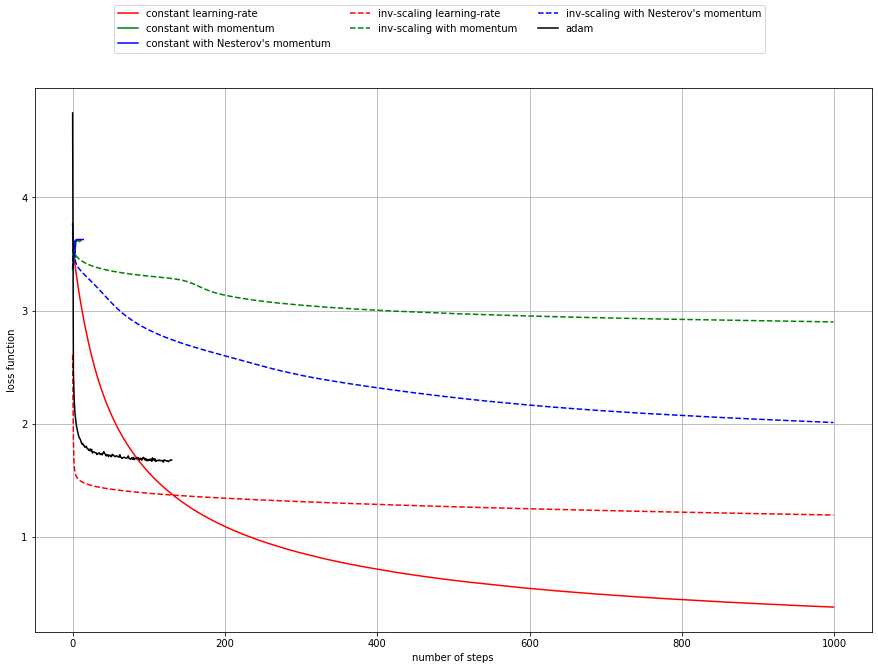

In [100]:
# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.001, 'hidden_layer_sizes': (1024), 'alpha':0.001},{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2, 'hidden_layer_sizes': (1024), 'alpha':0.001},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2, 'hidden_layer_sizes': (1024), 'alpha':0.001},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2, 'hidden_layer_sizes': (1024), 'alpha':0.001},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2, 'hidden_layer_sizes': (1024), 'alpha':0.001},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2, 'hidden_layer_sizes': (1024), 'alpha':0.001},
          {'solver': 'adam', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (1024), 'alpha':0.001}
         ]
# labels for each collection of parameters
labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]
# plotting arguments
plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]

# plot the results
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
mlps = []

# loop through each set of parameters
for label, param, args in zip(labels, params, plot_args):
    print("training: %s" % label)
    mlp = MLPClassifier(verbose=4, random_state=0, max_iter = 1000, **param)
    
    # some parameter combinations will not converge as can be seen on the
        # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning,
                                    module="sklearn")
            
    mlp.fit(X_train, y_train_final)
    mlps.append(mlp)
    print("Training set score: %f" % mlp.score(X_train, y_train_final))
    print("Training set loss: %f" % mlp.loss_)
    print('')
    axes.plot(mlp.loss_curve_, **args)

# show the plot
fig.legend(axes.get_lines(), labels=labels, ncol=3, loc="upper center")
plt.xlabel("number of steps")
plt.ylabel("loss function")
plt.grid(True)
plt.savefig('../plots/classifier/mlp/mlp_loss_curve_v2_1000.png')
plt.show()

In [111]:
X_VALID = X_valid_preprocessed.reshape((len(X_valid_preprocessed)),-1)
best_mlp_classifier = mlps[0]
vsc = best_mlp_classifier.score(X_VALID, y_valid)
print("Validation set score: %f" % vsc)

Validation set score: 0.817914


### 5.3. Testing MLP using Test dataset

In [102]:
#best_mlp_classifier = random_search_clf.best_estimator_
best_mlp_classifier = mlps[0]
print(best_mlp_classifier)
X_test_pp = X_test_preprocessed.reshape((len(X_test_preprocessed)),-1)
y_pred = best_mlp_classifier.predict(X_test_pp)
acc = accuracy_score(y_test,y_pred)
print("Test accuracy:",acc)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=1024, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=4, warm_start=False)
Test accuracy: 0.8135391923990499


### 3.3. Classification Report

In [103]:
m = multilabel_confusion_matrix(y_test, y_pred)
#print(type(m))
#print(m.shape, m.ndim)
print(m[0])
print("Classification report for classifier %s:\n%s\n"
      % (best_mlp_classifier, metrics.classification_report(y_test, y_pred)))

[[12563     7]
 [   48    12]]
Classification report for classifier MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=1024, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=4, warm_start=False):
              precision    recall  f1-score   support

           0       0.63      0.20      0.30        60
           1       0.80      0.85      0.82       720
           2       0.75      0.92      0.83       750
           3       0.82      0.80      0.81       450
           4       0.74      0.79      0.77       660
           5       0.77      0.66      0.71       630
           6       0.75      0.51      0.61       15

### 5.4 Confusion Metric

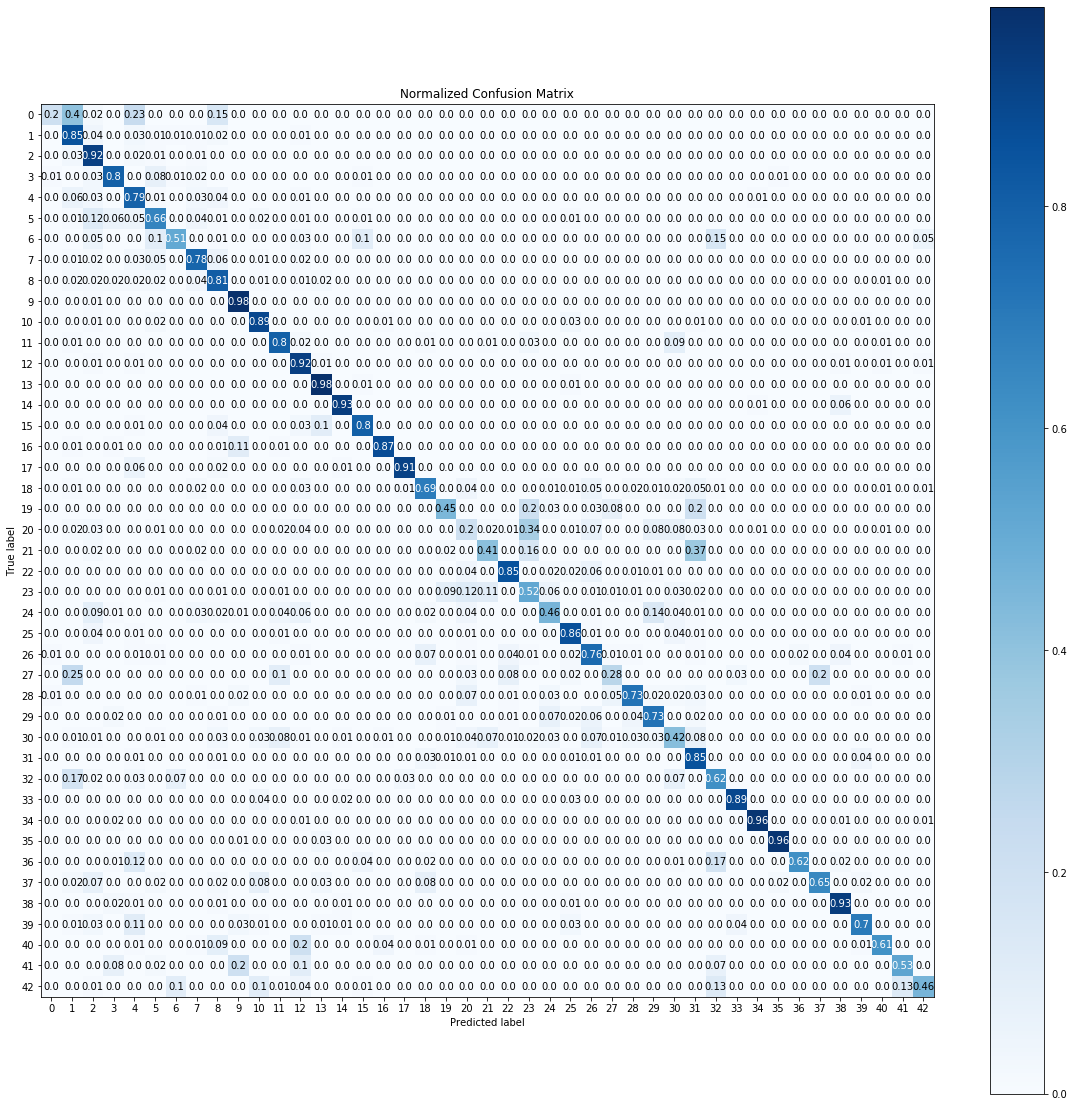

In [104]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred,figsize=(20,20), normalize=True)

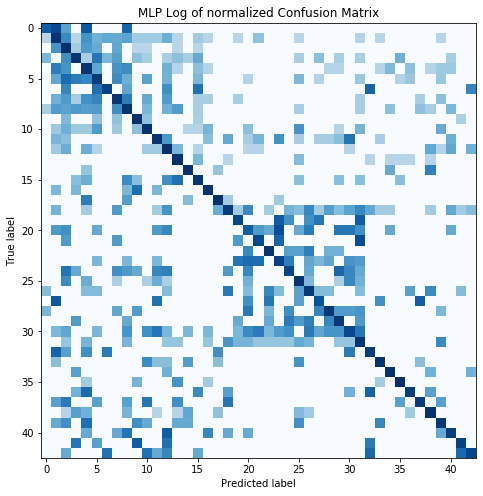

In [105]:
cm = confusion_matrix(y_test,y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MLP Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('../plots/classifier/mlp//log_confusion_mat_2.png')
plt.show()

### 5.5. Testing MLP Model on New Images.

In [106]:
### Loading and resizing new test images
new_test_images = []
path = '../data/traffic_sign_images/'
for image in sorted(os.listdir(path)):
    #print('Reading:', path+image)
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [13, 3, 14, 27, 17, 1,  14, 30, 25, 29, 11, 8,  31, 31, 30, 4, 1, 2, 27, 18]
#print("Number of new testing examples: ", len(new_test_images), 'Signs:', len(new_IDs))

In [107]:
# New test data preprocessing
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))
new_test_images_dataset = new_test_images_preprocessed.reshape(len(new_test_images_preprocessed),-1)

In [108]:
validation_labels = best_mlp_classifier.predict(new_test_images_dataset)
predict_probas = best_mlp_classifier.predict_proba(new_test_images_dataset)
sorted_probs = np.argsort(predict_probas)
top_k = len(best_mlp_classifier.classes_) - 5

New Images Test Accuracy = 25.0%


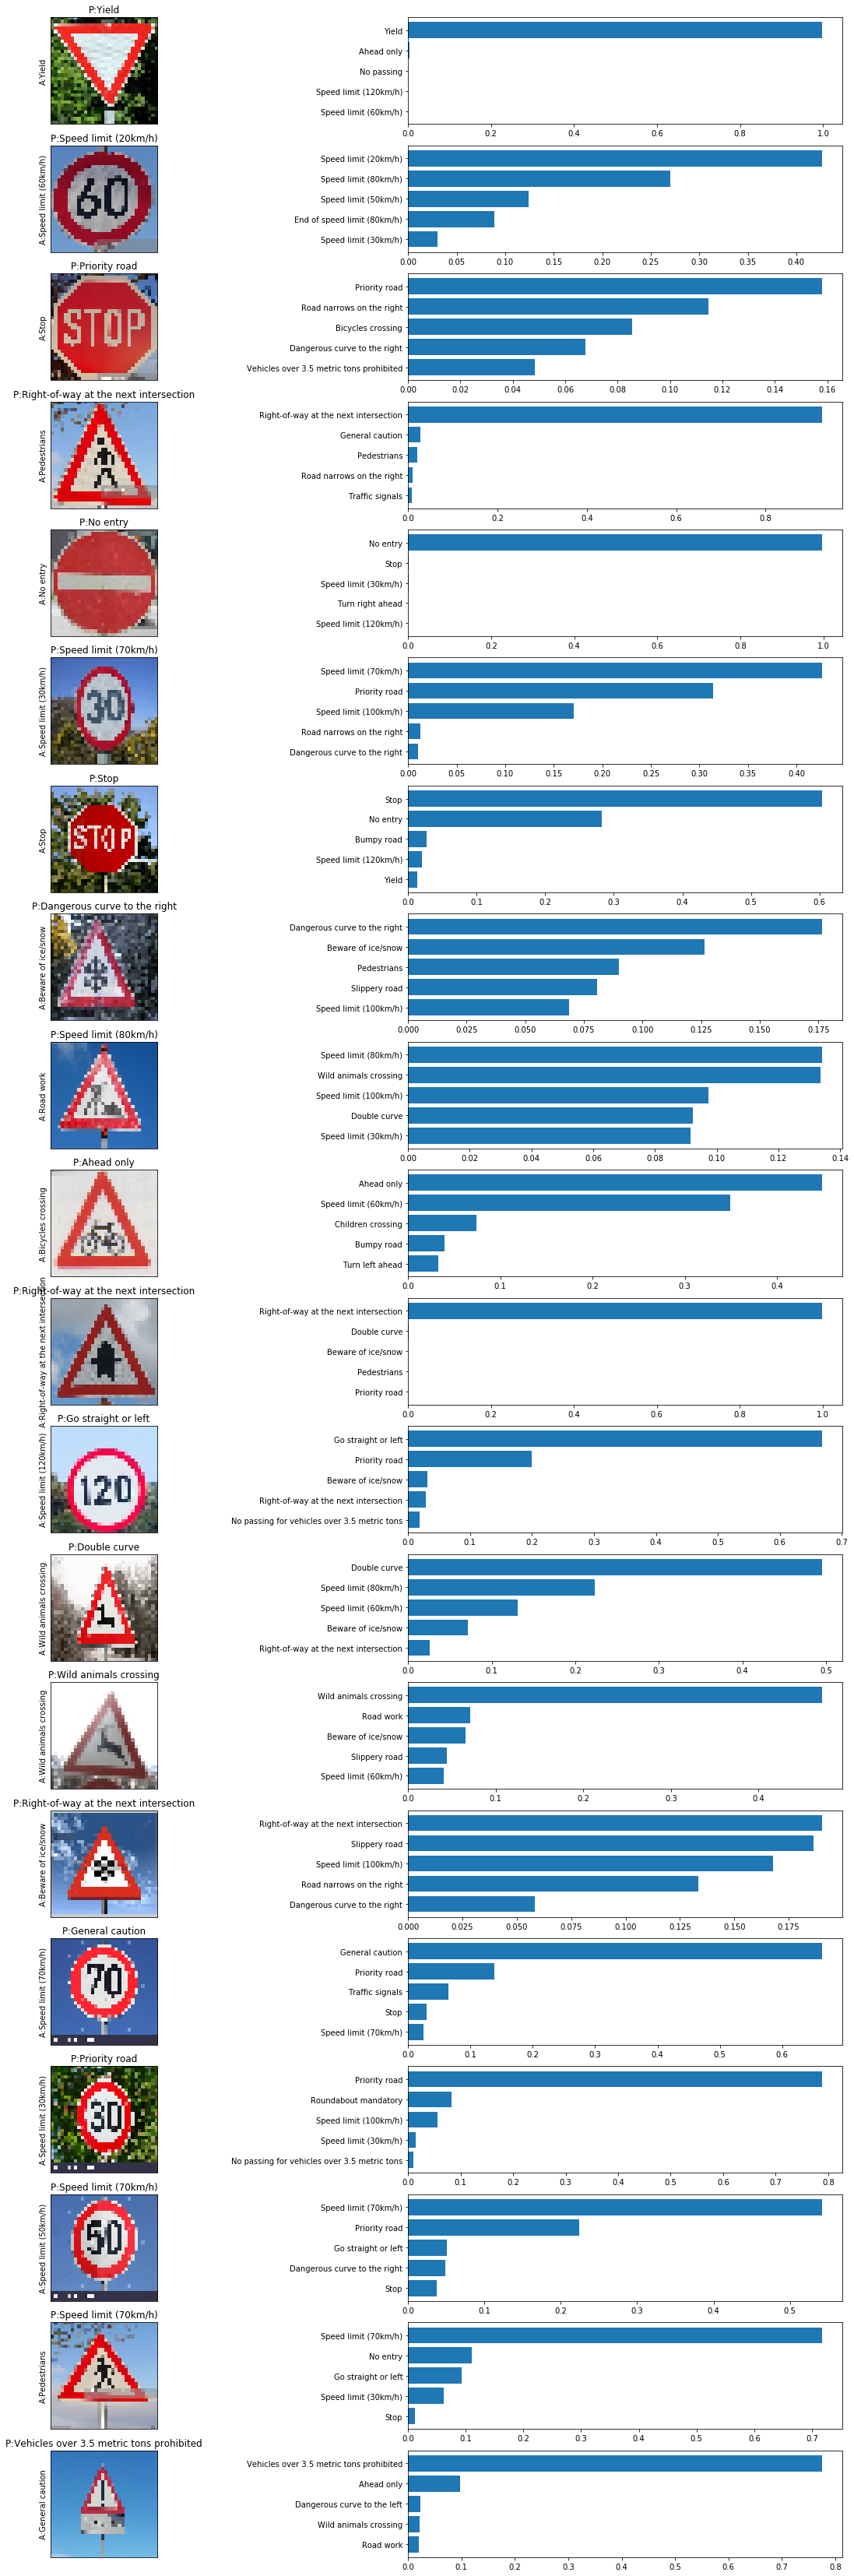

In [109]:
new_test_images_len=len(new_test_images_preprocessed)
plt.figure(figsize=(22, 60))
plt.title("MLP RESULTS")
test_accuracy = 0
for i in range(new_test_images_len):
    
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    actual = signs[new_IDs[i]]
    #print('LABEL:',actual)
    #plt.title('Actual:'+actual+'\nPredicted: '+signs[y_pred[i][0]])
    plt.title('P:'+signs[validation_labels[i]])
    plt.ylabel('A:'+actual)
    accu = new_IDs[i] == validation_labels[i]
    #print('new_IDs[i]->',new_IDs[i], 'validation_labels[i]->',validation_labels[i] )
    if accu == True:
        test_accuracy +=1
    plt.xticks([])
    plt.yticks([])
    
    
    high_probs = sorted_probs[i:(i+1),top_k:].flatten()
    labels = [signs[int(j)] for j in high_probs]
    temp =[predict_probas[i:(i+1),y] for y in high_probs]
    y_prob = np.array(temp).flatten()
    
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob)
    #labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
    
    #for x in high_probs:
        #cl_pre_prb = predict_probas[i:(i+1),x]
        #np.append(cl_pre_prb,y_prob)
    #print(cl_pre_prb.shape)  
print("New Images Test Accuracy = {:.1f}%".format((test_accuracy/new_test_images_preprocessed.shape[0])*100))
plt.savefig('../plots/classifier/mlp/mlp_new Image_acc.png')